In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib widget

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

-223.059124


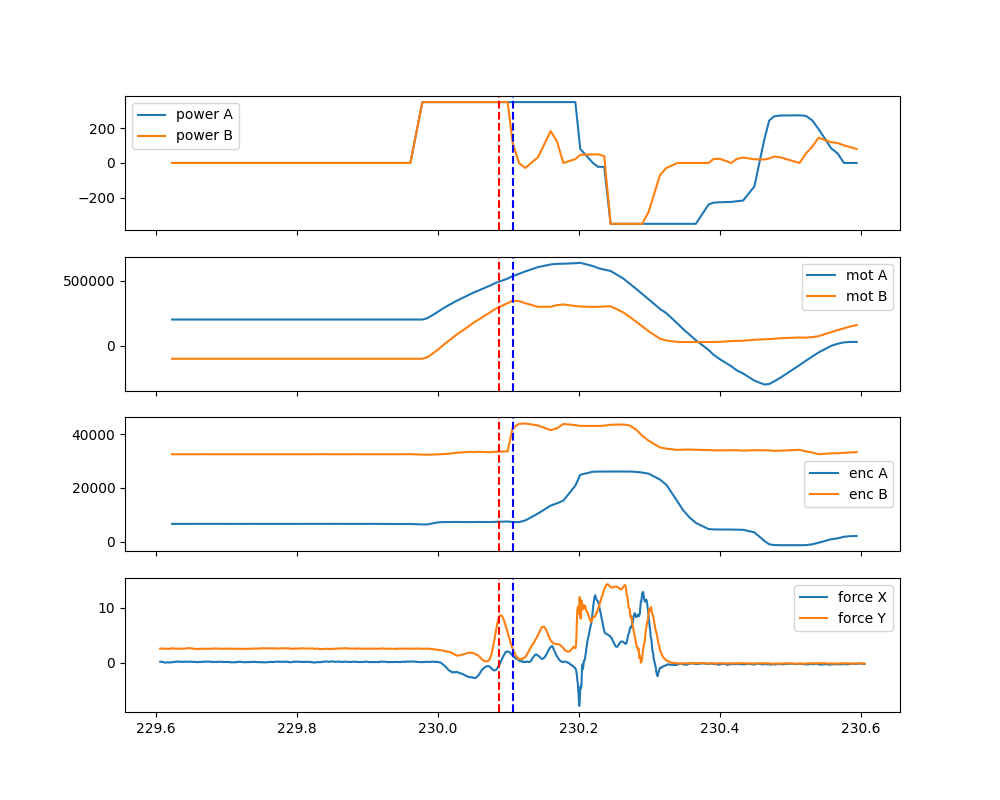

In [15]:
import glob, os

encoder_file = max(glob.glob('./data/*encoder.txt'), key=os.path.getctime)
force_file = max(glob.glob('./data/*force.txt'), key=os.path.getctime)

df_log = extract_from_txt(
    encoder_file, 
    [
        't',
        'pA',
        'pB',
        'mA',
        'mB',
        'eA', 
        'eB', 
        'I'
    ],
    '#'
)

force_data_path = force_file[:-4] + '_filt.txt'
remove_even_lines(force_file, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)


df_log.loc[:,'time'] = df_log.loc[:,'t'] / 1e3
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])
df_log['side_mot_pow'] = -df_log['pA']
df_log['center_mot_pow'] = -df_log['pB']


df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force['Fx'] = -df_force['N23']
df_force['Fy'] = df_force['N67']

manual_offset = 0.02
time_before = 0.5
time_after = 0.5


force_thres_t = df_force[df_force['Fy'] > 8]['time'].iloc[0]
enc_thres_t = df_log[df_log['center_enc_pos'] > 4e4]['time'].iloc[0]
offset = force_thres_t - enc_thres_t + manual_offset
# offset = 0
print(offset)

df_force.loc[:,'time'] = df_force.loc[:,'time'] - offset


df_log = df_log[df_log['time'] > enc_thres_t - time_before]
df_log = df_log[df_log['time'] < enc_thres_t + time_after]
df_log = df_log.reset_index()

df_force = df_force[df_force['time'] > enc_thres_t - time_before]
df_force = df_force[df_force['time'] < enc_thres_t + time_after]
df_force = df_force.reset_index()



fig, axs = plt.subplots(4,1,figsize=(10,8), sharex=True)
axs[0].plot(df_log['time'], df_log['side_mot_pow'], label='power A')
axs[0].plot(df_log['time'], df_log['center_mot_pow'], label='power B')
axs[1].plot(df_log['time'], df_log['side_mot_pos'], label='mot A')
axs[1].plot(df_log['time'], df_log['center_mot_pos'], label='mot B')
axs[2].plot(df_log['time'], df_log['side_enc_pos'], label='enc A')
axs[2].plot(df_log['time'], df_log['center_enc_pos'], label='enc B')
axs[3].plot(df_force['time'], df_force['Fx'], label='force X')
axs[3].plot(df_force['time'], df_force['Fy'], label='force Y')
for ax in axs:
    ax.legend()


for ax in axs:
    ax.axvline(x=force_thres_t - offset, color='r', linestyle='--')
    ax.axvline(x=enc_thres_t, color='b', linestyle='--')



XML: ./data/C0011M01(shared).XML
track.csv: ./data/C0008_track.csv
Capture FPS: 959.04
Format FPS: 29.97
playback_speed: 0.03125
time at liftoff: 0.322196875
Average omega after liftoff: -6.889618730961592


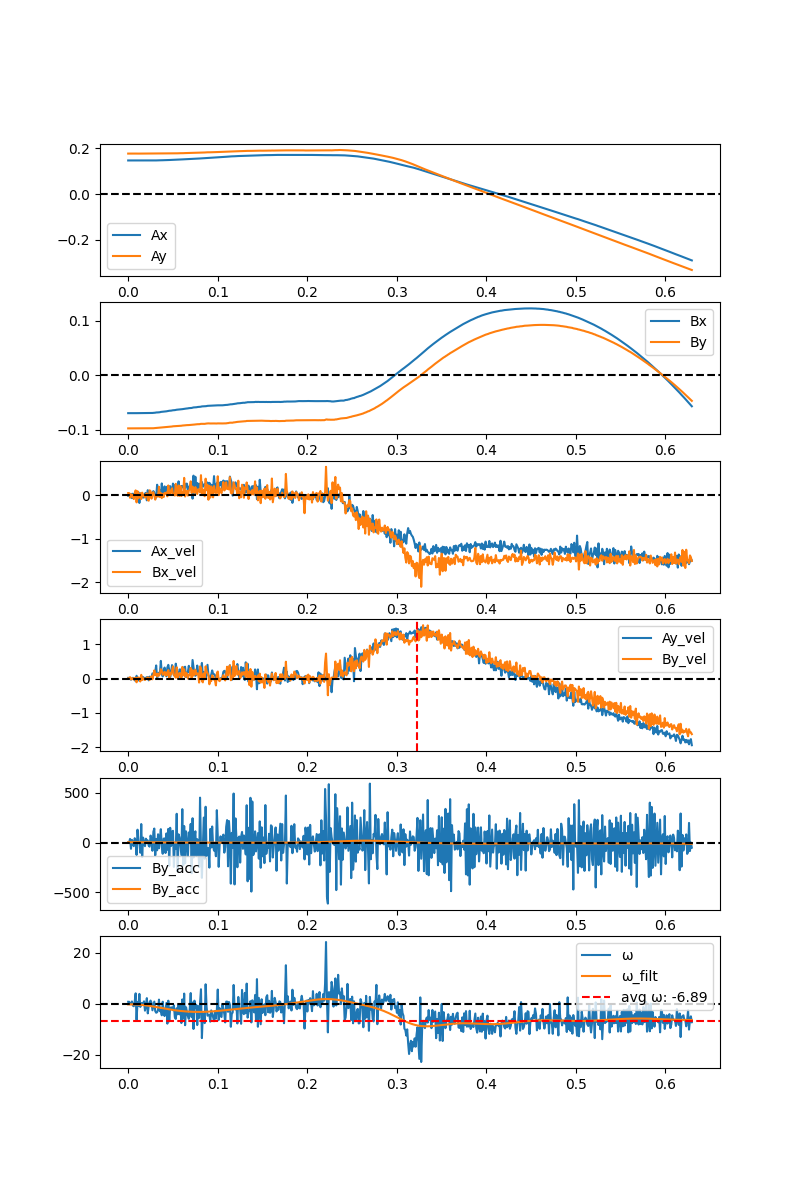

In [18]:
''' Video data '''
import xml.etree.ElementTree as ET
import os
import glob

track_files = glob.glob('./data/*track.csv')
xml_files = glob.glob('./data/*.XML')
latest_track_file = max(track_files, key=os.path.getctime)
latest_xml_file = max(xml_files, key=os.path.getctime)

def extract_fps(xml_string):
    root = ET.fromstring(xml_string)
    video_frame = root.find('.//*[@captureFps][@formatFps]')
    if video_frame is not None:
        capture_fps = str(video_frame.get('captureFps'))
        format_fps = str(video_frame.get('formatFps'))
        return float(capture_fps[:-1]), float(format_fps[:-1])
    else:
        return np.nan, np.nan

with open(latest_xml_file, 'r') as file:
    xml_content = file.read()
capture_fps, format_fps = extract_fps(xml_content)
playback_speed = format_fps / capture_fps

print(f"XML: {latest_xml_file}")
print(f"track.csv: {latest_track_file}")
print(f"Capture FPS: {capture_fps}")
print(f"Format FPS: {format_fps}")
print(f"playback_speed: {playback_speed}")

df = pd.read_csv(latest_track_file)
df['t'] = df['t'] * playback_speed
df['Ax_vel'] = df['Ax'].diff() / df['t'].diff()
df['Ax_vel'][0] = df['Ax_vel'][1]
df['Ay_vel'] = df['Ay'].diff() / df['t'].diff()
df['Ay_vel'][0] = df['Ay_vel'][1]
df['Bx_vel'] = df['Bx'].diff() / df['t'].diff()
df['Bx_vel'][0] = df['Bx_vel'][1]
df['By_vel'] = df['By'].diff() / df['t'].diff()
df['By_vel'][0] = df['By_vel'][1]

r12x = df['Bx'] - df['Ax']
r12y = df['By'] - df['Ay']
v12x = df['Bx_vel'] - df['Ax_vel']
v12y = df['By_vel'] - df['Ay_vel']

df['By_acc'] = df['By_vel'].diff() / df['t'].diff()
df['By_acc'][0] = df['By_acc'][1]
df['By_acc_filt'] = butterworth_filter(df['By_acc'], 10, capture_fps)

# v12x[0] = v12x[1]
# v12y[0] = v12y[1]

omega = (r12x*v12y - r12y*v12x) / (r12x**2 + r12y**2)
df['omega'] = omega
df['omega_filt'] = butterworth_filter(df['omega'], 10, capture_fps)

i_liftoff = np.where(np.diff(np.sign(df['By_acc_filt'])))[0][-1]
average_omega_after_liftoff = df['omega'].iloc[i_liftoff:].mean()
print(f"time at liftoff: {df['t'][i_liftoff]}")
print(f"Average omega after liftoff: {average_omega_after_liftoff}")

fig, axs = plt.subplots(6,1, figsize=(8,12))
axs[0].plot(df['t'], df['Ax'], label='Ax')
axs[0].plot(df['t'], df['Bx'], label='Ay')
axs[1].plot(df['t'], df['Ay'], label='Bx')
axs[1].plot(df['t'], df['By'], label='By')

axs[2].plot(df['t'], df['Ax_vel'], label='Ax_vel')
axs[2].plot(df['t'], df['Bx_vel'], label='Bx_vel')

axs[3].plot(df['t'], df['Ay_vel'], label='Ay_vel')
axs[3].plot(df['t'], df['By_vel'], label='By_vel')
axs[3].axvline(x=df['t'][i_liftoff], color='r', linestyle='--')

axs[4].plot(df['t'], df['By_acc'], label='By_acc')
axs[4].plot(df['t'], df['By_acc_filt'], label='By_acc')

axs[5].plot(df['t'], df['omega'], label='ω')
axs[5].plot(df['t'], df['omega_filt'], label='ω_filt')
axs[5].axhline(y=average_omega_after_liftoff, color='r', linestyle='--', label=f'avg ω: {average_omega_after_liftoff:.3}')





for ax in axs:
    ax.axhline(0, linestyle='--', color='k')
    ax.legend()



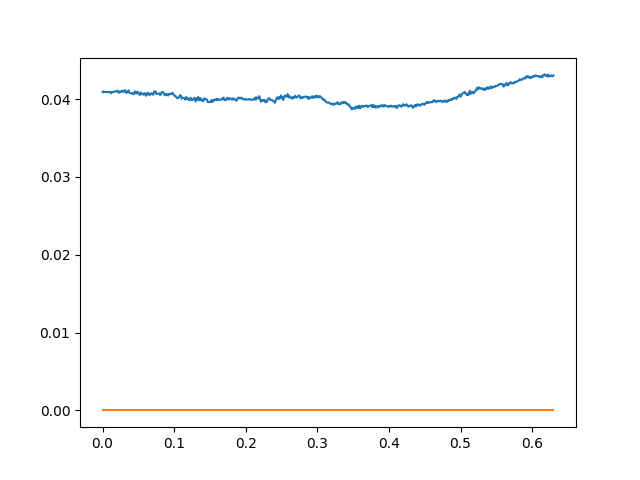

In [21]:
r12_mag = np.linalg.norm([r12x, r12y], axis=0)
plt.figure()
plt.plot(df['t'], r12_mag) #to see how much the distance between markers varies in the camera, how on plane the jump is
plt.plot(df['t'], np.zeros_like(df['t']))

In [117]:
import casadi



opti = casadi.Opti()
r1x = opti.variable()
r1y = opti.variable()
r2x = opti.variable()
r2y = opti.variable()



opti.set_initial(r1x, 0)

In [112]:
plt.close('all')